# Integrator RNN tutorial

In this notebook, we train a vanilla RNN to integrate white noise.  This example is useful on its own to understand how RNN training works, and how to use JAX.  In addition, it provides the input for the LFADS JAX tutorial. 

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Imports

In [1]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import
import datetime
import h5py
import jax.numpy as np
from jax import random
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import numpy as onp             # original CPU-backed NumPy
import os
import sys
import time
from importlib import reload

In [2]:
# Import the tutorial code.

# You must change this to the location of computation-thru-dynamics directory.
HOME_DIR = '/home/sussillo/' 

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
import integrator_rnn_tutorial.integrator as integrator
import integrator_rnn_tutorial.rnn as rnn
import integrator_rnn_tutorial.utils as utils

### Hyperparameters

In [3]:
# Integration parameters
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 25  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

# Integrator RNN hyperparameters
u = 1         # Number of inputs to the RNN
n = 100       # Number of units in the RNN
o = 1         # Number of outputs in the RNN

# The scaling of the recurrent parameters in an RNN really matters. 
# The correct scaling is 1/sqrt(number of recurrent inputs), which 
# yields an order 1 signal output to a neuron if the input is order 1.
# Given that VRNN uses a tanh nonlinearity, with min and max output 
# values of -1 and 1, this works out.  The scaling just below 1 
# (0.95) is because we know we are making a line attractor so, we 
# might as well start it off basically right 1.0 is also basically 
# right, but perhaps will lead to crazier dynamics.
param_scale = 0.85 # Scaling of the recurrent weight matrix

# Optimization hyperparameters
num_batchs = 10000         # Total number of batches to train on.
batch_size = 128          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.025          # initial learning rate
decay_factor = 0.99975     # decay the learning rate this much
# Gradient clipping is HUGELY important for training RNNs
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.0002           # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 100          # Print training informatino every so often

Seed: 695940


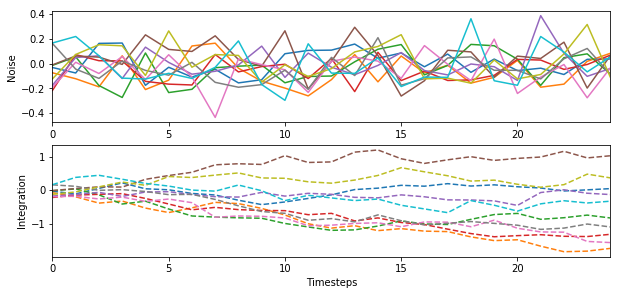

In [4]:
# JAX handles randomness differently than numpy or matlab. 
# one threads the randomness through to each function. 
#  It's a bit tedious, but very easy to understand and with
# reliable effect.
seed = onp.random.randint(0, 1000000) # get randomness from CPU level numpy
print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot a few input/target examples to make sure things look sane.
ntoplot = 10    # how many examples to plot
# With this split command, we are always getting a new key from the old key,
# and I use first key as as source of randomness for new keys.
#     key, subkey = random.split(key, 2)
#     ## do something random with subkey
#     key, subkey = random.split(key, 2)
#     ## do something random with subkey
# In this way, the same top level randomness source stays random.

# The number of examples to plot is given by the number of 
# random keys in this function.
key, skey = random.split(key, 2)
skeys = random.split(skey, ntoplot) # get ntoplot random keys
inputs, targets = integrator.build_inputs_and_targets_jit(input_params, skeys)

# Plot the input to the RNN and the target for the RNN.
integrator.plot_batch(ntimesteps, inputs, targets)

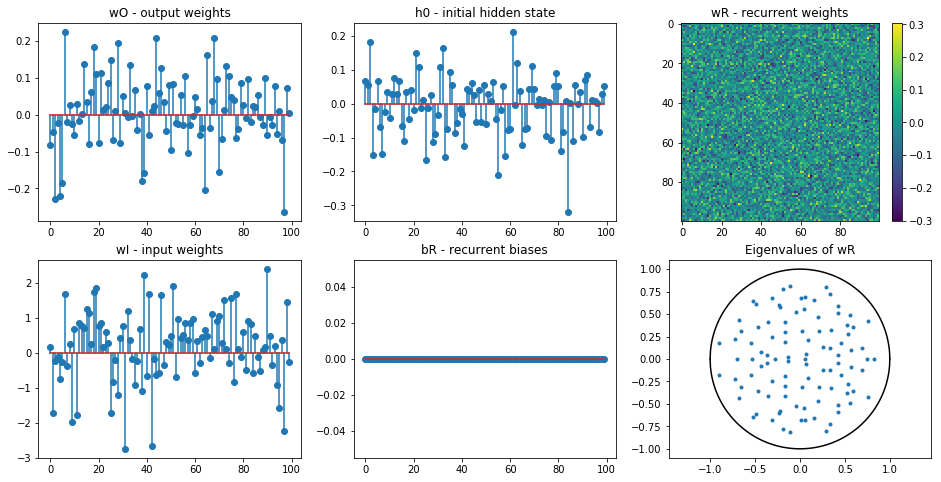

In [5]:
# Init some parameters for training.
key, subkey = random.split(key, 2)
init_params = rnn.random_vrnn_params(subkey, u, n, o, g=param_scale)
rnn.plot_params(init_params)

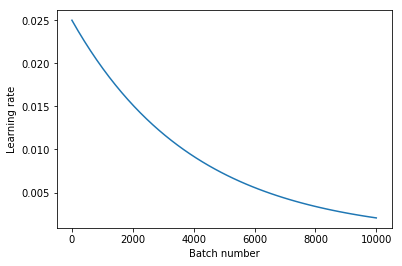

In [6]:
# Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(step_size, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = onp.linspace(1, num_batchs)
plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

### Train the VRNN

In [7]:
reload(rnn)
# Initialize the optimizer.  Please see jax/experimental/optimizers.py
opt_init, opt_update, get_params = optimizers.adam(decay_fun, adam_b1, adam_b2, adam_eps)
opt_state = opt_init(init_params)

# Run the optimization loop, first jit'd call will take a minute.
start_time = time.time()
all_train_losses = []
for batch in range(num_batchs):
    key, subkey = random.split(key, 2)
    skeys = random.split(subkey, batch_size)
    inputs, targets = integrator.build_inputs_and_targets_jit(input_params, skeys)
    opt_state = rnn.update_w_gc_jit(batch, opt_state, opt_update, get_params, inputs,
                                  targets, max_grad_norm, l2reg)
    if batch % print_every == 0:
        params = get_params(opt_state)
        all_train_losses.append(rnn.loss_jit(params, inputs, targets, l2reg))
        train_loss = all_train_losses[-1]['total']
        batch_time = time.time() - start_time
        step_size = decay_fun(batch)
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
        print(s.format(batch, batch_time, step_size, train_loss))
        start_time = time.time()
        
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Batch 0 in 8.78 sec, step size: 0.02500, training loss 0.2227
Batch 100 in 0.83 sec, step size: 0.02438, training loss 0.0475
Batch 200 in 0.75 sec, step size: 0.02378, training loss 0.0370
Batch 300 in 0.76 sec, step size: 0.02319, training loss 0.0384
Batch 400 in 0.78 sec, step size: 0.02262, training loss 0.0348
Batch 500 in 0.82 sec, step size: 0.02206, training loss 0.0360
Batch 600 in 0.81 sec, step size: 0.02152, training loss 0.0372
Batch 700 in 0.80 sec, step size: 0.02099, training loss 0.0326
Batch 800 in 0.77 sec, step size: 0.02047, training loss 0.0324
Batch 900 in 0.78 sec, step size: 0.01996, training loss 0.0318
Batch 1000 in 0.77 sec, step size: 0.01947, training loss 0.0310
Batch 1100 in 0.77 sec, step size: 0.01899, training loss 0.0313
Batch 1200 in 0.76 sec, step size: 0.01852, training loss 0.0303
Batch 1300 in 0.77 sec, step size: 0.01806, training loss 0.0311
Batch 1400 in 0.78 sec, step size: 0.01762, training loss 0.0293
Batch 1500 in 0.78 sec, step size: 0.

Text(0.5,1,'All losses')

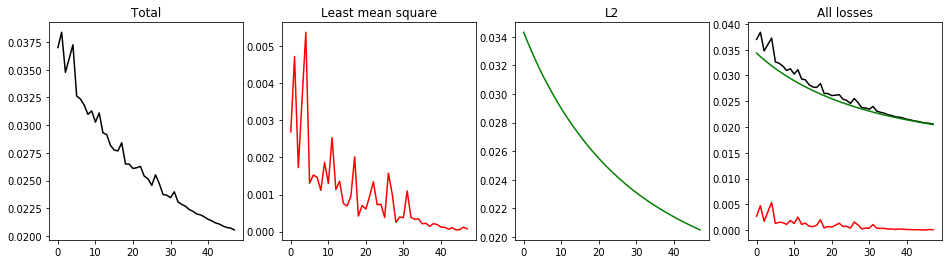

In [8]:
# Show the loss through training.
xlims = [2, 50]
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(all_train_losses['total'][xlims[0]:xlims[1]], 'k')
plt.title('Total')

plt.subplot(142)
plt.plot(all_train_losses['lms'][xlims[0]:xlims[1]], 'r')
plt.title('Least mean square')

plt.subplot(143)
plt.plot(all_train_losses['l2'][xlims[0]:xlims[1]], 'g');
plt.title('L2')

plt.subplot(144)
plt.plot(all_train_losses['total'][xlims[0]:xlims[1]], 'k')
plt.plot(all_train_losses['lms'][xlims[0]:xlims[1]], 'r')
plt.plot(all_train_losses['l2'][xlims[0]:xlims[1]], 'g')
plt.title('All losses')

### Testing

In [9]:
# Take a batch for an evalulation loss, notice the L2 penalty is 0
# for the evaluation.
params = get_params(opt_state)

key, subkey = random.split(key, 2)
skeys = random.split(subkey, batch_size)
inputs, targets = integrator.build_inputs_and_targets_jit(input_params, skeys)
eval_loss = rnn.loss_jit(params, inputs, targets, l2reg=0.0)['total']
eval_loss_str = "{:.5f}".format(eval_loss)
print("Loss on a new large batch: %s" % (eval_loss_str))

Loss on a new large batch: 0.00002


### Visualizations of trained system

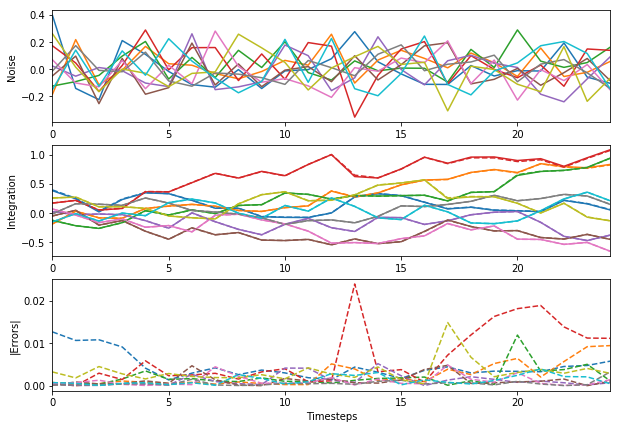

In [10]:
reload(rnn)

# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b = \
        integrator.build_inputs_and_targets_jit(input_params, keys)
    h0s_b = None # Use trained h0
    return inputs_b, targets_b, h0s_b

rnn_run = lambda inputs: rnn.batched_rnn_run(params, inputs)

give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

rnn_internals = rnn.run_trials(rnn_run, inputs_targets_no_h0s, 1, 16)

integrator.plot_batch(ntimesteps, rnn_internals['inputs'], 
                      rnn_internals['targets'], rnn_internals['outputs'], 
                      onp.abs(rnn_internals['targets'] - rnn_internals['outputs']))

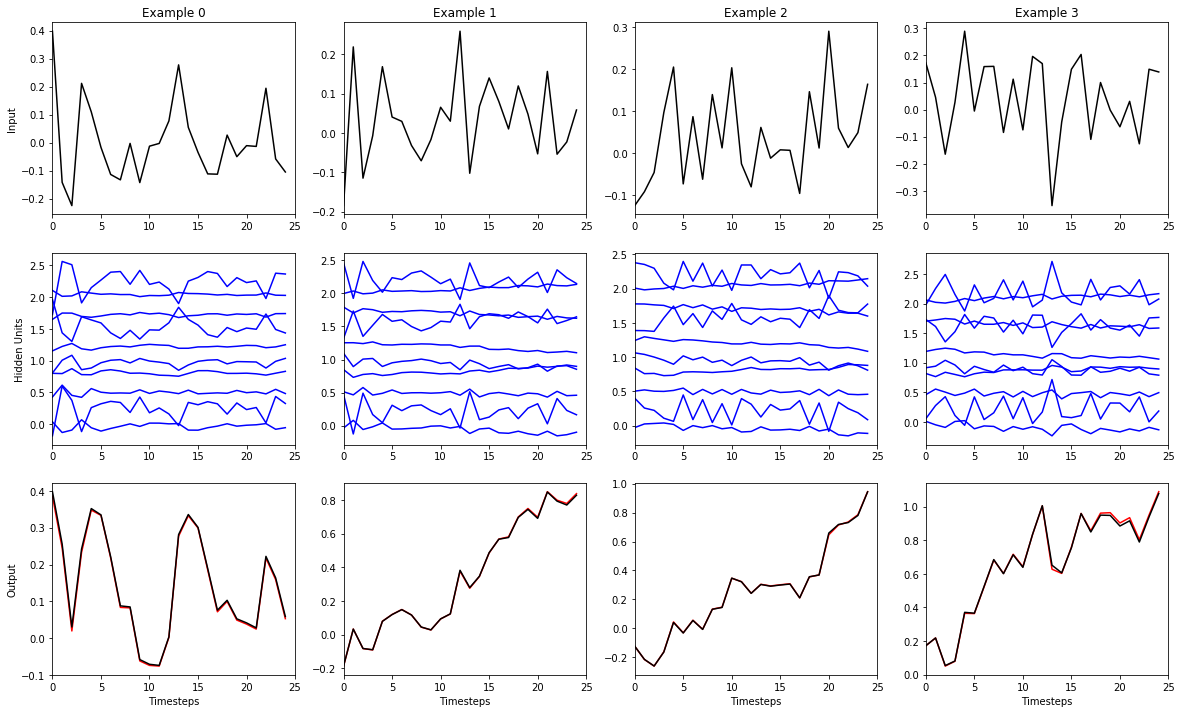

In [11]:
# Visualize the hidden state, as an example.
rnn.plot_examples(ntimesteps, rnn_internals, nexamples=4)

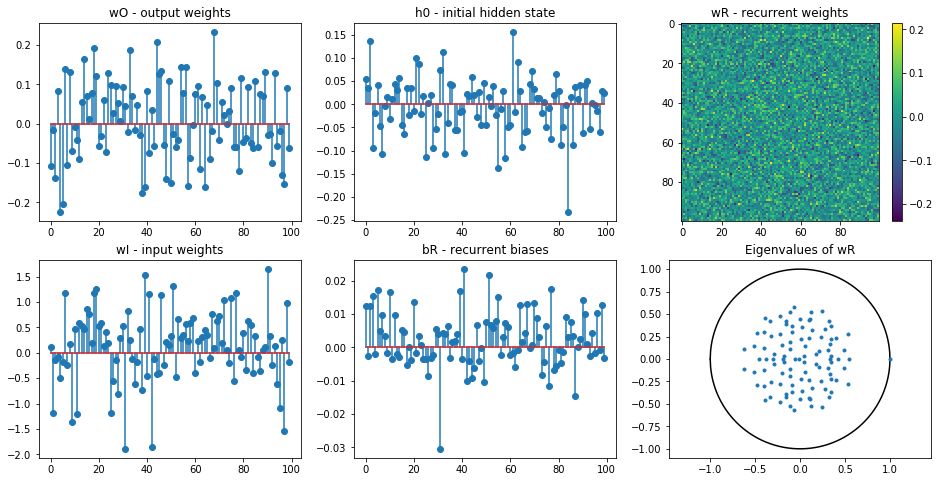

In [12]:
# Take a look at the trained parameters.
rnn.plot_params(params)

### Saving

In [13]:
# Define directories, etc.
task_type = 'pure_int'
rnn_type = 'vrnn'
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
data_dir = os.path.join(os.path.join('/tmp', rnn_type), task_type)

print(data_dir)
print(fname_uniquifier)

/tmp/vrnn/pure_int
2019-06-19_15:12:45


In [14]:
# Save parameters

params_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                eval_loss_str + '_' + fname_uniquifier + '.h5')
params_fname = os.path.join(data_dir, params_fname)

print("Saving params in %s" % (params_fname))
utils.write_file(params_fname, params)

Saving params in /tmp/vrnn/pure_int/trained_params_vrnn_pure_int_0.00002_2019-06-19_15:12:45.h5


### Create per-trial initial conditions along the line attractor.
Let's create some per-trial initial conditions by running the integrator for a few time steps. This will make comparing the learned initial states in the LFADS tutorial easier to visualize.

In [15]:
nsave_batches = 20 # Save about 20000 trials

h0_ntimesteps = 7 # Only a few steps, we don't wanna get too far out of it's range.
h0_input_params = (bval, sval,  
                   T * float(h0_ntimesteps) / float(ntimesteps), 
                   h0_ntimesteps)

In [16]:
def get_h0s_inputs_targets_h0s(keys):
    inputs_bxtxu, targets_bxtxm = \
        integrator.build_inputs_and_targets_jit(h0_input_params, keys)
    B, T, U = inputs_bxtxu.shape
    _, _, M = targets_bxtxm.shape
    # We add a zero to the end of the input so that the network will "snap back"
    # to the line attractor, which will make comparing the learned initial states 
    # in the LFADS example easier to visualize.
    inputs_bxtp1xu = np.concatenate([inputs_bxtxu, np.zeros([B, 1, U])], axis=1)
    targets_bxtp1xm = np.concatenate([targets_bxtxm, targets_bxtxm[:, -1:, :]], axis=1)
                                    
    h0s = give_trained_h0(len(keys))
    return (inputs_bxtp1xu, targets_bxtp1xm, h0s)
    
rnn_run_w_h0 = lambda inputs, h0s: rnn.batched_rnn_run_w_h0(params, inputs, h0s)

h0_data_dict = rnn.run_trials(rnn_run_w_h0, get_h0s_inputs_targets_h0s, 
                              nsave_batches, eval_batch_size)

The saved trials will *begin* with initial conditions that are the *end* of these trials.

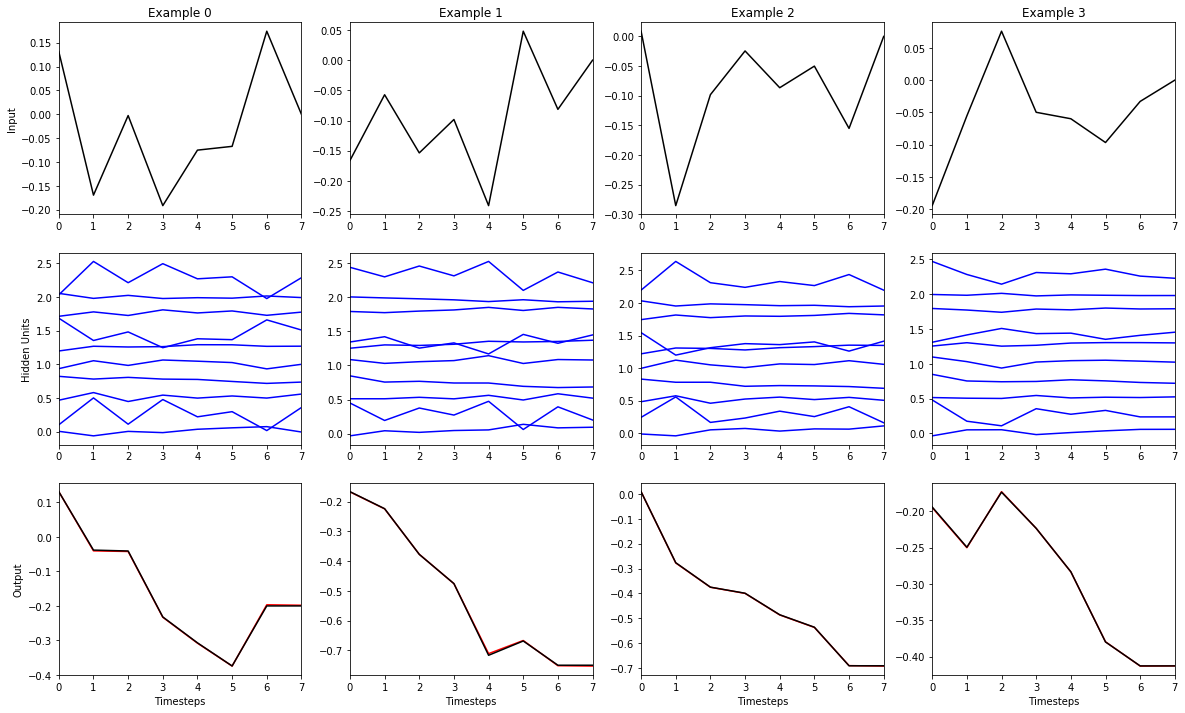

In [17]:
rnn.plot_examples(h0_ntimesteps, h0_data_dict, nexamples=4)

In [18]:
### Save some trials, this is for the LFADS tutorial, and no need 
### to save this otherwise.
h0s_bxn = h0_data_dict['hiddens'][:, -1, :] # take last time step

# This generator is a damned hack, but it's a throw-away method
# for making h0s.
h0gen = (h0 for h0 in h0s_bxn)
def h0s_on_a_line_fun(batch_size):
    """Spit out batch_size h0s at a time as nd.array."""
    h0s = []
    for b in range(batch_size):
        h0s.append(next(h0gen))
    return onp.array(h0s)


def use_h0s_inputs_targets_h0s(keys):
    """Use the line attractro h0s for the saved data."""
    inputs_b, targets_b = \
        integrator.build_inputs_and_targets_jit(input_params, keys)
    h0s_b = h0s_on_a_line_fun(len(keys))
    
    # Target has to updated based on differing initial condition.
    offsets_b = rnn.batch_affine(params, h0s_b)
    targets_b = targets_b + np.expand_dims(offsets_b, axis=2)
    return inputs_b, targets_b, h0s_b

# Save about 20,000 trials for playing around with the LFADS tutorial.
data_dict = rnn.run_trials(rnn_run_w_h0, use_h0s_inputs_targets_h0s, nsave_batches,
                           eval_batch_size)

data_fname = ('trained_data_' + rnn_type + '_' + task_type + '_' + \
              eval_loss_str + '_' + fname_uniquifier + '.h5')
data_fname = os.path.join(data_dir, data_fname)
print("Saving data in %s" %(data_fname))
utils.write_file(data_fname, data_dict)

Saving data in /tmp/vrnn/pure_int/trained_data_vrnn_pure_int_0.00002_2019-06-19_15:12:45.h5


Finally, here are some example trials that are saved. Notice the hidden state starts now from different positions on the line and the integrator integrates for a larger number of time steps.  This will allow the LFADS tutorial to infer the intial state (along the line), the white noise input, and the underlying rates (which are 'spikified' in the LFADS example).

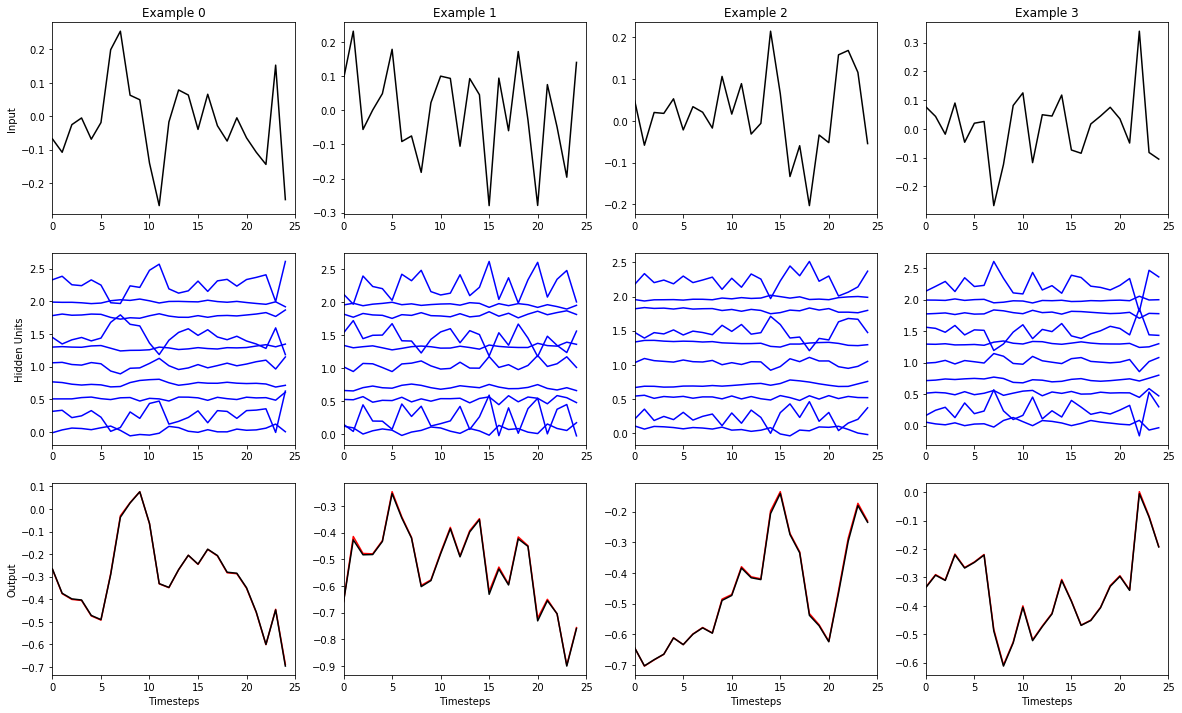

In [19]:
rnn.plot_examples(ntimesteps, data_dict, nexamples=4)